# Prediction of the metric for benchmarking an extreme fast-charging of Li-ion battery electrode materials

We introduce a universal metric for Benchmarking battery electrode Materials for eXtreme Fast Charging (BMX-FC) as the maximum State-of-Charge (SOC) value reached when a material is charged for 15 minutes under constant current conditions. The BMX-FC takes a value of 1 when the electrode is fully charged, a value of 0.8 when it satisfies the USABC criteria (80% of the charge in 15 minutes) and lower values when they are not directly applicable as fast-charging electrodes under the USABC conditions. The BMX-FC pretends to standarize comparisions between the performance of different materials to be applied in fast-charging LIBs electrodes. The BMX-FC allows us to establish a hierarchy of materials according to its value.

We base our discussion about this metric by using a galvanostatic model that considers finite-diffusion and interfacial kinetic effects that are controlled by the following four parameters:
1. diffusion coefficient of the ions inside the material ($D$),
2. rate constant for charge transfer ($k^0$),
3. C-rate ($C_r$),
4. particle size ($d$).

Note that BMX-FC can also be determined experimentally or from other simulation methods. In our case, we will use [galpynostatic package](https://github.com/fernandezfran/galpynostatic).

## Data cleaning

First we import all the libraries that we will use in this notebook.

In [1]:
import os
import pathlib

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import pandas as pd
import scipy.stats

DATA_PATH = pathlib.Path(os.path.abspath(os.path.join("..", "datasets")))
PREDICTIONS_PATH = pathlib.Path(os.path.abspath(os.path.join("..", "predictions")))

In [2]:
import galpynostatic as gp
gp.VERSION

'0.3.3'

We load the data of the Supporting Information of the paper of [Xia et al](https://pubs.acs.org/doi/abs/10.1021/acsnano.2c03922):

In [3]:
experimental_data = pd.read_csv(DATA_PATH / "experimental_data.csv")
experimental_data

,Material,particle_size_micro,dcoeff_cm2s
0,LCO,5-10,1e-11 to 1e-7
1,LCO,NaN,1e-10 to 1.5e-9
2,LCO,0.5,1e-10 to 1e-8
3,LCO,1-5,4e-11 to 1.7e-10
4,LCO,0.1,1.34e-11
5,LMO,0.2,9.04e-11
6,LMO,NaN,1.5e-12
7,LMO,0.3,2.97e-12
8,LMO,2-5,1.57e-7
9,LMO,10,1e-9 to 1e-7


In Xia et al.'s work, they propose the characteristic time of diffusion as a Figure Of Merit (FOM), $\tau = \frac{d^2}{D}$, that we will use to compare with our BMX-FC.

For parameters involved we will use the mean experimental value, in the case that the value is missing we will fill it with the mean of the family, as is also done by Xia et al.

We can start by defining an extra column with the mean characteristic lenght in $\mu$m (`d_mean_micro`). We must consider that the values are separated by a middle gion ("-"), so we can split the string in each row by this character and then take the mean by changing each string to a float and by taking care of the NaN values:

In [4]:
experimental_data["d_mean_micro"] = experimental_data["particle_size_micro"].str.split("-").apply(
    lambda x: np.mean([float(i) for i in x]) 
    if isinstance(x, list) 
    else np.nan
).copy()

Some values are missing so we fill them with the mean of the Family group:

In [5]:
experimental_data["d_mean_micro"] = experimental_data.groupby(
    "Material", group_keys=False
)["d_mean_micro"].apply(lambda x: x.fillna(x.mean())).copy()

Same can be done for the diffusion coefficient but now the values are separated with the string " to " and we do not have any NaN value

In [6]:
~experimental_data["dcoeff_cm2s"].isna().any()

True

The diffusion coefficient values are spread over a wide range of order of magnitudes, so we use the _geometric mean_ because it is a more appropriate measure than the _arithmetic mean_ which would be dominated by the larger value.

In [7]:
experimental_data["dcoeff_midpoint_cm2s"] = experimental_data["dcoeff_cm2s"].str.split(" to ").apply(
    lambda x: scipy.stats.gmean([float(i) for i in x])
).copy()

**Disclaimer**: the points in the Xia et al. chart will be displaced from their publication due to they use the _aritmetic mean_.

We will use in this example the following $k^0$ value because is the midpoint of the distribution of the experimental works consulted

In [8]:
K0 = 1e-7

We will define some Python dicts that will be used in the following plots and are common to two or more of them

In [9]:
systems = experimental_data["Material"].unique()

marker, color, socs, opss, opcrs, taus = {}, {}, {}, {}, {}, {}
for sys, m, c in zip(systems, ("s", "o", "D", "^", "v", "<"), (None, "red", "pink", "blue", "green", "orange")):
    marker[sys] = m
    color[sys] = f"tab:{c}" if c is not None else "k"
    socs[sys], opss[sys], opcrs[sys], taus[sys] = [], [], [], []

In [10]:
spherical = pd.read_csv(DATA_PATH / "simulated_map.csv")

## Metric preprocessing

The four parametrs described at the beggining of this notebook ($D$, $k^0$, $C_r$, $d$) can be used to compute the dimensionless parameters of the galvanostatic model used in galpynsotatic:
$$
\Xi = k^0 \sqrt{\frac{t_h}{C_r D}}; \hspace{0.4cm} \ell = \frac{d^2}{2} \left(\frac{C_r}{D t_h}\right)
$$
and use them to give color to each bar in the predictions plot.

In [11]:
for sys, dcoeff, d in experimental_data[
    ["Material", "dcoeff_midpoint_cm2s", "d_mean_micro"]
].values:
    info = {"d": 1e-4 * d, "dcoeff_": dcoeff, "k0_": K0}
    soc = gp.metric.umbem(info, dataset=spherical)

    soc = soc if ~np.isnan(soc) else 0.0
    socs[sys].append(soc)

## Predictions of the optimal particle size and charging rate of the electrode material

Predictions are made for the size that the particle in the electrode must be to obtain 80% of the charge in 15 minutes. 

In the plot, this size data is normalised by experimental size to allow a better comparison of experiments that can increase in size by one order of magnitude without considerable loss of charge retention with those extreme cases where a decrease of the size of two orders of magnitude would be necessary. The colour of each bar in the histogram is given by its initial performance, since with the new size they would all have the colour of the metric corresponding to 0.8.

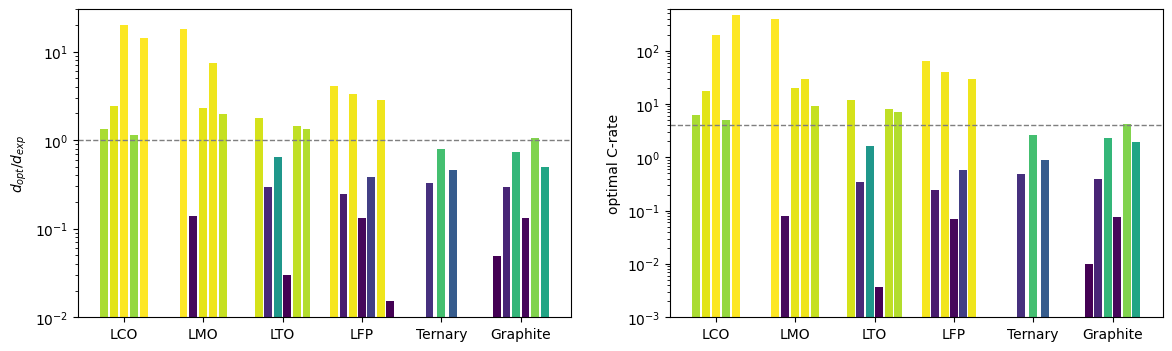

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))

cmap = cm.get_cmap("viridis")

for i, (sys, dcoeff, d) in enumerate(
    experimental_data[
        ["Material", "dcoeff_midpoint_cm2s", "d_mean_micro"]
    ].values
):
    info = {"d": 1e-4 * d, "dcoeff_": dcoeff, "k0_": K0}
    umbem = gp.metric.umbem(info, full_output=True, dataset=spherical)
    greg = umbem["greg"]
    
    d0 = 1e-5 * d
    if i in [5, 24, 30]:
        d0 = 10.0 * d0
    elif i in [11, 12, 13, 14]:
        d0 = 1e-4 * d
    elif i == 23:
        d0 = 0.3 * d0
        
    try:
        ops = gp.make_prediction.optimal_particle_size(greg, d0=d0)
    except ValueError as e:
        num = 100
        if i in [22, 24]:
            num = 1000
        elif i in [12, 14]:
            num = 225        
                                  
        loggrid = np.logspace(-7, -4, num=num)
        for d0 in loggrid:
            try:
                ops = gp.make_prediction.optimal_particle_size(greg, d0=d0)
                break
            except ValueError as e:
                ...
    finally:
        opss[sys].append(ops / d)
    
    c0 = 1.0
    if i in [6, 14, 16, 17, 29]:
        c0 = 0.1
    elif i in [9, 13, 19, 22, 23, 26]:
        c0 = 0.0025
    
    try:
        greg.d = 1e-4 * d
        opcr = gp.make_prediction.optimal_charging_rate(greg, c0=c0)
    except ValueError as e:
        ...
    finally:
        opcrs[sys].append(opcr)
        
x = np.linspace(0, 1, num=len(socs.keys()))
w = 0.02
for i, (ops, opcr, soc) in enumerate(
    zip(opss.values(), opcrs.values(), socs.values())
):
    colors = [cmap(v) for v in soc]
    xs = np.linspace(x[i] - (w / 2) * len(ops), x[i] + (w / 2) * len(ops), num=len(ops))
    
    ax1.bar(xs, ops, width=w, color=colors)
    ax2.bar(xs, opcr, width=w, color=colors)

ax1.axhline(y=1, color="tab:gray", linestyle="dashed", linewidth=1)
ax1.set_xticks(x)
ax1.set_xticklabels(opss.keys())
ax1.set_yscale("log")
ax1.set_ylim((0.01, 30))
ax1.set_ylabel(r"$d_{opt} / d_{exp}$")

ax2.axhline(y=4, color="tab:gray", linestyle="dashed", linewidth=1)
ax2.set_xticks(x)
ax2.set_xticklabels(opcrs.keys())
ax2.set_yscale("log")
ax2.set_ylim((0.001, 600))
ax2.set_ylabel("optimal C-rate")

plt.show()

We now save the predictions in different files, first for optimal particle size:

In [13]:
experimental_data["optimal_particle_size"] = np.concatenate(
    np.asarray(list(opss.values()), dtype=object)
) * experimental_data["d_mean_micro"]

experimental_data[
    ["Material", "d_mean_micro", "dcoeff_midpoint_cm2s", "optimal_particle_size"]
].to_csv(PREDICTIONS_PATH / "particle_sizes.csv", index=False)

and now for optimal charging rate:

In [14]:
experimental_data["optimal_charging_rate"] = np.concatenate(np.asarray(list(opcrs.values()), dtype=object))

experimental_data[
    ["Material", "d_mean_micro", "dcoeff_midpoint_cm2s", "optimal_charging_rate"]
].to_csv(PREDICTIONS_PATH / "charging_rates.csv", index=False)